In [1]:
import os
import cv2
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, VGG16, VGG19, InceptionResNetV2, MobileNetV3Large,Xception
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


### Loading Data

In [2]:
IMAGE_SIZE = (224, 224)  
NUM_CLASSES = 2         # Binary classification
np.random.seed(10)  # For NumPy

# Function to load and preprocess images
def load_dataset(directory, label_map):
    images = []
    labels = []
    for label_name, label_value in label_map.items():
        folder = os.path.join(directory, label_name)
        for file in os.listdir(folder):
            if file.endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(folder, file)
                img = cv2.imread(file_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                img = cv2.resize(img, IMAGE_SIZE)  # Resize
                img = img / 255.0  # Normalize to 0-1
                images.append(img)
                labels.append(label_value)
    return np.array(images), np.array(labels)


### Preparing Training, Validation and Test Sets

In [3]:
# Define label mapping
label_map = {'benign': 0, 'malignant': 1}

# Load train dataset
X_train, y_train = load_dataset('data/Train/', label_map)

# Shuffle the training data
indices = np.arange(X_train.shape[0])  # Create indices
np.random.shuffle(indices)             # Shuffle indices
X_train = X_train[indices]             # Apply shuffled indices
y_train = y_train[indices]

# Split train into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Shuffle validation set 
indices_val = np.arange(X_val.shape[0])
np.random.shuffle(indices_val)
X_val = X_val[indices_val]
y_val = y_val[indices_val]

# Load test dataset
X_test, y_test = load_dataset('data/Test/', label_map)

### Number of Each Label in Training, Validation and Test Set

In [20]:
# Print dataset shapes
print(f"Train set: {X_train.shape},\n Validation set: {X_val.shape},\n Test set: {X_test.shape}")
# Function to count occurrences of each label in a dataset
def count_labels(y, set_name):
    unique, counts = np.unique(y, return_counts=True)
    print(f"{set_name} Set - Benign: {counts[0]}, Malignant: {counts[1]}")

count_labels(y_train, "\nTraining")
count_labels(y_val, "Validation")
count_labels(y_test, "Test")


Train set: (2109, 224, 224, 3),
 Validation set: (528, 224, 224, 3),
 Test set: (660, 224, 224, 3)

Training Set - Benign: 1160, Malignant: 949
Validation Set - Benign: 280, Malignant: 248
Test Set - Benign: 360, Malignant: 300


#####
#### Showing Random Images from Training, Validation and Test Sets

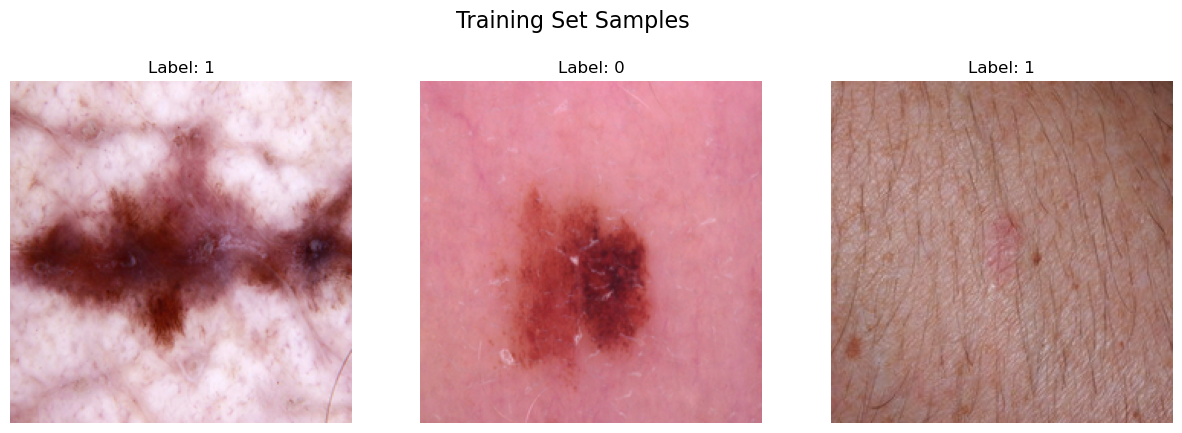

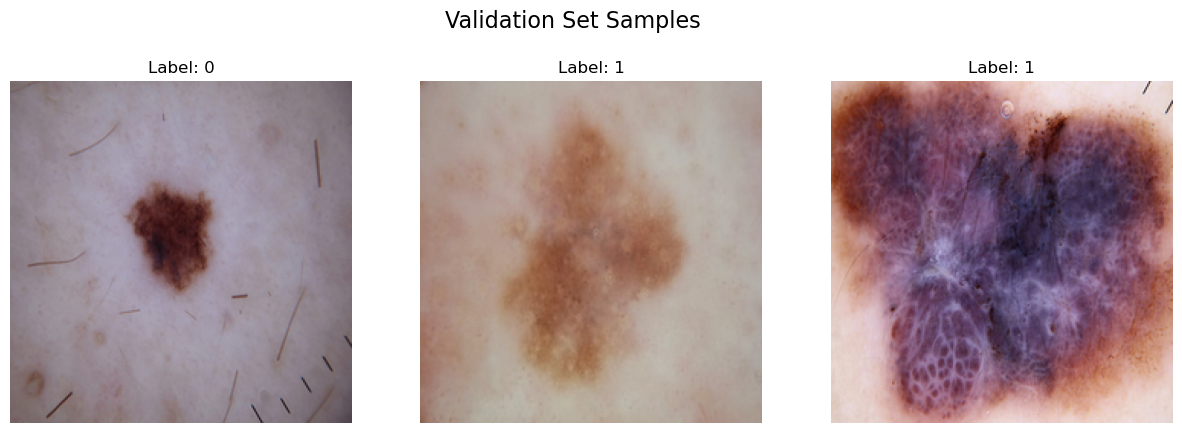

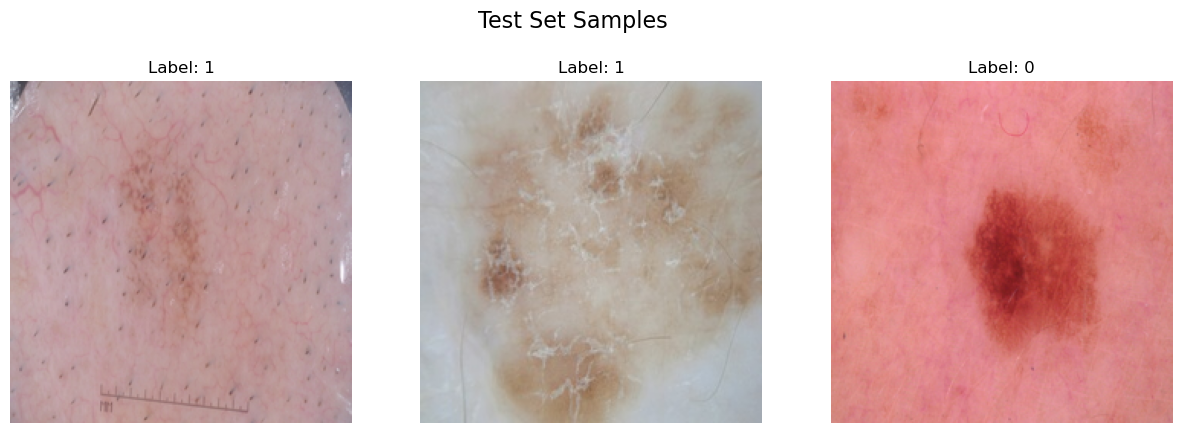

In [5]:
def show_random_images(images, labels, title, num_samples=3):

    indices = np.random.choice(len(images), num_samples, replace=False)  # Random indices
    plt.figure(figsize=(15, 5))  # Adjust figure size
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx])  # Display the image
        plt.title(f"Label: {labels[idx]}")
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

show_random_images(X_train, y_train, "Training Set Samples", num_samples=3)
show_random_images(X_val, y_val, "Validation Set Samples", num_samples=3)
show_random_images(X_test, y_test, "Test Set Samples", num_samples=3)


# Training ANN 

In [8]:
# Define a simple ANN
ann_model = Sequential([
    Flatten(input_shape=(224, 224, 3)),  # Flatten image input
    Dense(128, activation='relu'),      # Hidden layer
    Dense(64, activation='relu'),       # Hidden layer
    Dense(1, activation='sigmoid')      # Single output neuron for binary classification
])

# Compile the model
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the ANN model without batching
history_ann = ann_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20  # Adjust epochs as needed
)

# Evaluate on the test set
test_loss_ann, test_acc_ann = ann_model.evaluate(X_test, y_test)
print(f"ANN Test Accuracy: {test_acc_ann}")


C:\Users\erfan\anaconda3\envs\my\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.5456 - loss: 11.3306 - val_accuracy: 0.5303 - val_loss: 8.3174
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.6512 - loss: 3.1375 - val_accuracy: 0.5303 - val_loss: 13.0721
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.6150 - loss: 4.7880 - val_accuracy: 0.4981 - val_loss: 3.8408
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.5962 - loss: 2.8259 - val_accuracy: 0.5246 - val_loss: 5.4772
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7266 - loss: 1.4536 - val_accuracy: 0.6856 - val_loss: 1.2532
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7331 - loss: 1.0332 - val_accuracy: 0.7538 - val_loss: 0.7490
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7251 - loss: 0.9668 - val_accuracy: 0.7689 - val_loss: 0.7027
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7518 - loss: 0.6941 - val_accuracy: 0.4716 -

# Training CNN

In [9]:
# Define a simple CNN
cnn_model = Sequential([
    Input(shape=(224, 224, 3)),  # Define the input shape explicitly
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model without batching
history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20  # Adjust epochs as needed
)

# Evaluate on the test set
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(X_test, y_test)
print(f"CNN Test Accuracy: {test_acc_cnn}")


Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 257ms/step - accuracy: 0.5767 - loss: 1.9814 - val_accuracy: 0.7045 - val_loss: 0.4965
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 251ms/step - accuracy: 0.7331 - loss: 0.5361 - val_accuracy: 0.7746 - val_loss: 0.4871
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 261ms/step - accuracy: 0.7781 - loss: 0.4478 - val_accuracy: 0.7273 - val_loss: 0.4732
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 271ms/step - accuracy: 0.7987 - loss: 0.3951 - val_accuracy: 0.7973 - val_loss: 0.3998
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 265ms/step - accuracy: 0.8199 - loss: 0.3478 - val_accuracy: 0.8144 - val_loss: 0.3820
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 261ms/step - accuracy: 0.8517 - loss: 0.3123 - val_accuracy: 0.8087 - val_loss: 0.3865
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 251ms/step - accuracy: 0.8570 - loss: 0.2958 - val_accuracy: 0.7992 - val_loss: 0.4065
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 254ms/step - accuracy: 0.8500 - loss: 0.2992 - val_accu

### Training Progress of ANN and CNN

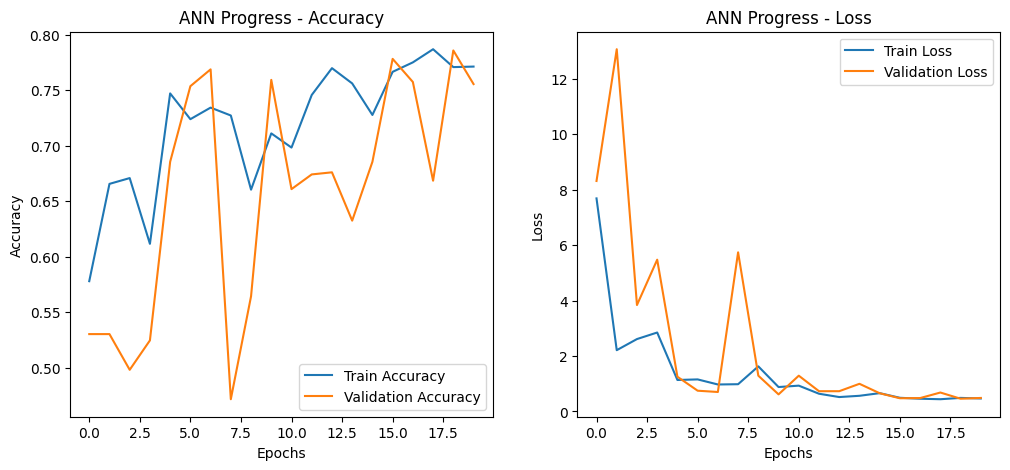

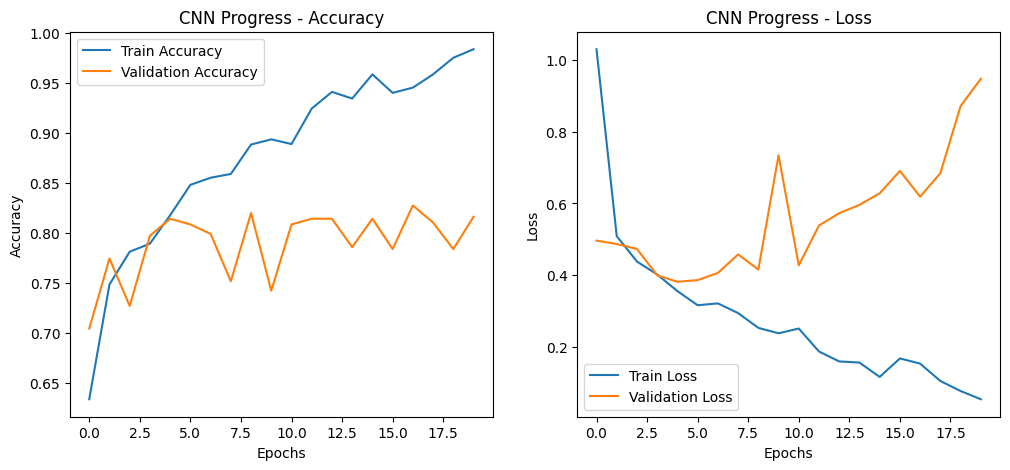

In [11]:
# Function to plot training and validation metrics
def plot_training_progress(history, title):

    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot progress for ANN
plot_training_progress(history_ann, "ANN Progress")

# Plot progress for CNN
plot_training_progress(history_cnn, "CNN Progress")


### Evaluation of ANN and CNN

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


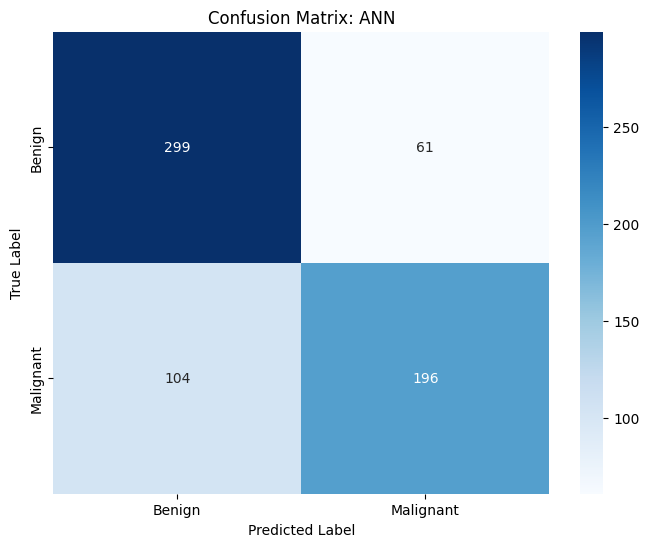

Performance Metrics for ANN:
              precision    recall  f1-score   support

      Benign       0.74      0.83      0.78       360
   Malignant       0.76      0.65      0.70       300

    accuracy                           0.75       660
   macro avg       0.75      0.74      0.74       660
weighted avg       0.75      0.75      0.75       660

Overall Accuracy: 0.75
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


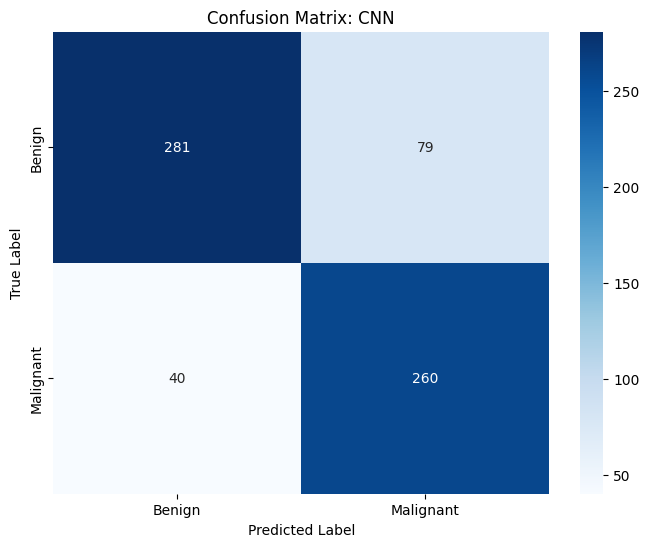

Performance Metrics for CNN:
              precision    recall  f1-score   support

      Benign       0.88      0.78      0.83       360
   Malignant       0.77      0.87      0.81       300

    accuracy                           0.82       660
   macro avg       0.82      0.82      0.82       660
weighted avg       0.83      0.82      0.82       660

Overall Accuracy: 0.82


In [12]:
def evaluate_model(model, X_test, y_test, title):

    # Predict probabilities and convert to binary predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)  # Threshold at 0.5 for binary classification

    # Convert labels to integer format for evaluation
    y_test_int = y_test.astype(int).flatten()

    # Confusion Matrix
    cm = confusion_matrix(y_test_int, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Metrics
    print(f"Performance Metrics for {title}:")
    print(classification_report(y_test_int, y_pred, target_names=['Benign', 'Malignant']))
    print(f"Overall Accuracy: {accuracy_score(y_test_int, y_pred):.2f}")

# Evaluate ANN
evaluate_model(ann_model, X_test, y_test, "ANN")

# Evaluate CNN
evaluate_model(cnn_model, X_test, y_test, "CNN")


# Training ANN with batch_size = 32

In [13]:
# Define a simple ANN
ann_model = Sequential([
    Flatten(input_shape=(224, 224, 3)),  # Flatten image input
    Dense(128, activation='relu'),      # Hidden layer
    Dense(64, activation='relu'),       # Hidden layer
    Dense(1, activation='sigmoid')      # Single output neuron for binary classification
])

# Compile the model
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_ann = ann_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  
    batch_size=32  
)

# Evaluate the test set
test_loss_ann, test_acc_ann = ann_model.evaluate(X_test, y_test, batch_size=32)
print(f"ANN Test Accuracy: {test_acc_ann}")

C:\Users\erfan\anaconda3\envs\my\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.5323 - loss: 16.8842 - val_accuracy: 0.7197 - val_loss: 0.6727
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6771 - loss: 0.9994 - val_accuracy: 0.7557 - val_loss: 0.6481
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7076 - loss: 0.9201 - val_accuracy: 0.7614 - val_loss: 0.7658
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6563 - loss: 1.2985 - val_accuracy: 0.7595 - val_loss: 0.6314
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7249 - loss: 0.8088 - val_accuracy: 0.7462 - val_loss: 0.6306
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7201 - loss: 0.8947 - val_accuracy: 0.6667 - val_loss: 0.8714
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7413 - loss: 0.7382 - val_accuracy: 0.7462 - val_loss: 0.6356
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7432 - loss: 0.6118 - val_accuracy: 0.7652 - 

# Training CNN with batch_size = 32

In [14]:
# Define a simple CNN
cnn_model = Sequential([
    Input(shape=(224, 224, 3)),  # Define the input shape explicitly
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  
    batch_size=32 
)

# Evaluate on the test set
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(X_test, y_test, batch_size=32)
print(f"CNN Test Accuracy: {test_acc_cnn}")


Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 277ms/step - accuracy: 0.6099 - loss: 2.3138 - val_accuracy: 0.7803 - val_loss: 0.5660
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 268ms/step - accuracy: 0.7557 - loss: 0.5210 - val_accuracy: 0.7992 - val_loss: 0.4336
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 265ms/step - accuracy: 0.7718 - loss: 0.4608 - val_accuracy: 0.8068 - val_loss: 0.4113
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.7963 - loss: 0.4050 - val_accuracy: 0.7973 - val_loss: 0.3966
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 261ms/step - accuracy: 0.7809 - loss: 0.4364 - val_accuracy: 0.7992 - val_loss: 0.4034
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 276ms/step - accuracy: 0.8265 - loss: 0.3613 - val_accuracy: 0.7784 - val_loss: 0.4913
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 287ms/step - accuracy: 0.8267 - loss: 0.3489 - val_accuracy: 0.8106 - val_loss: 0.4266
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 293ms/step - accuracy: 0.8566 - loss: 0.2932 - val_accu

### Training Progress of ANN and CNN with batch_size = 32

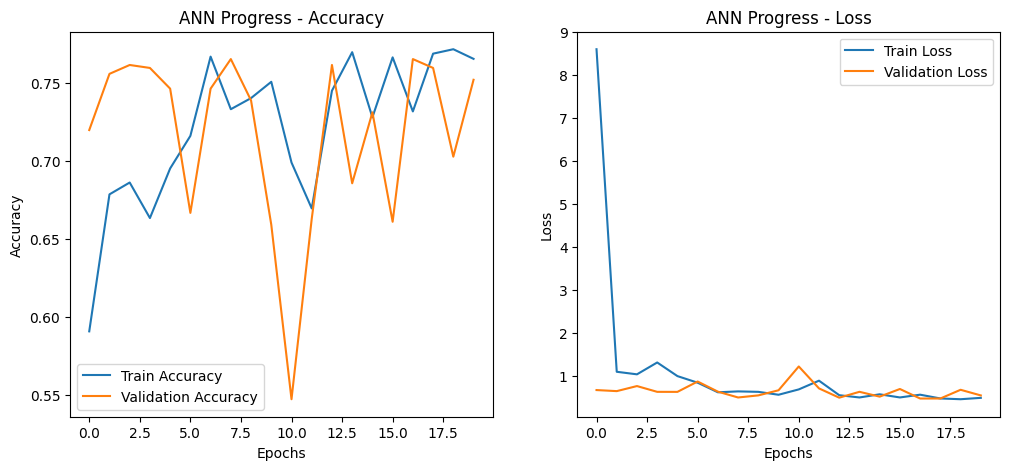

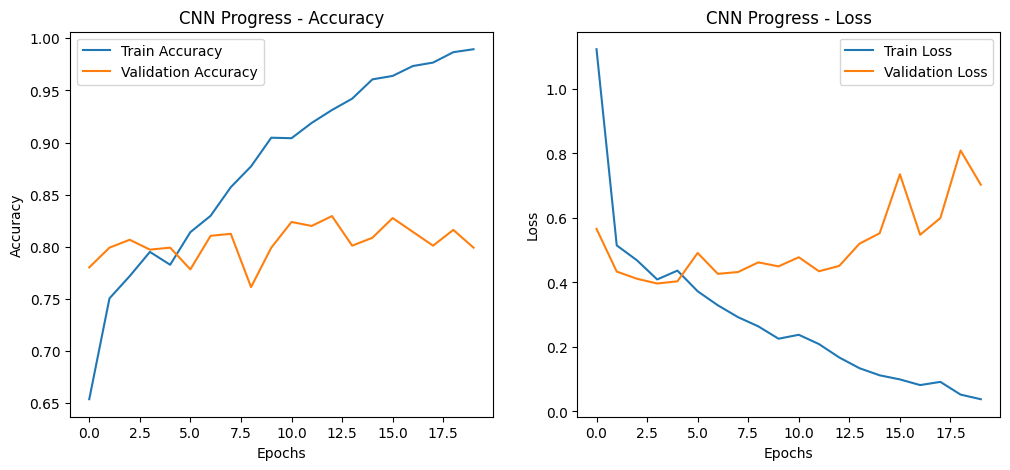

In [16]:
# Function to plot training and validation metrics
def plot_training_progress(history, title):

    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot progress for ANN
plot_training_progress(history_ann, "ANN Progress")

# Plot progress for CNN
plot_training_progress(history_cnn, "CNN Progress")


### Evaluation of ANN and CNN with batch_size = 32

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


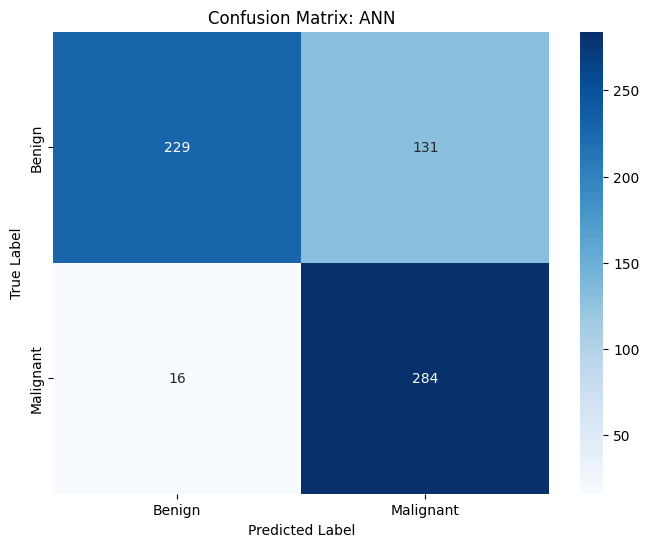

Performance Metrics for ANN:
              precision    recall  f1-score   support

      Benign       0.93      0.64      0.76       360
   Malignant       0.68      0.95      0.79       300

    accuracy                           0.78       660
   macro avg       0.81      0.79      0.78       660
weighted avg       0.82      0.78      0.77       660

Overall Accuracy: 0.78
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


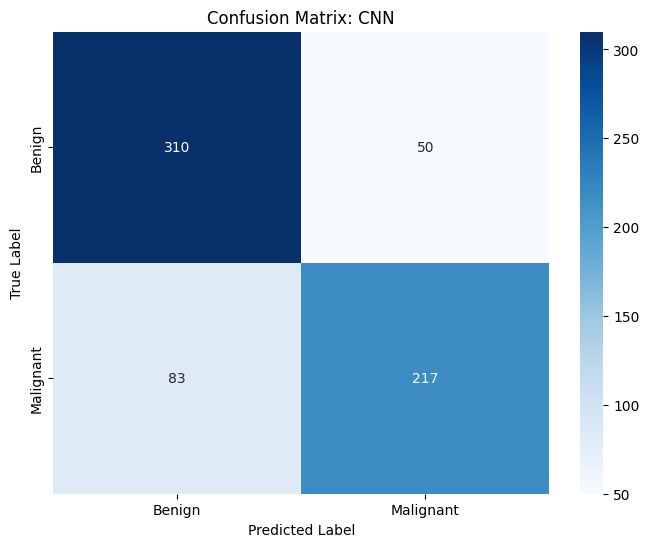

Performance Metrics for CNN:
              precision    recall  f1-score   support

      Benign       0.79      0.86      0.82       360
   Malignant       0.81      0.72      0.77       300

    accuracy                           0.80       660
   macro avg       0.80      0.79      0.79       660
weighted avg       0.80      0.80      0.80       660

Overall Accuracy: 0.80


In [17]:
def evaluate_model(model, X_test, y_test, title):

    # Predict probabilities and convert to binary predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)  # Threshold at 0.5 for binary classification

    # Convert labels to integer format for evaluation
    y_test_int = y_test.astype(int).flatten()

    # Confusion Matrix
    cm = confusion_matrix(y_test_int, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Metrics
    print(f"Performance Metrics for {title}:")
    print(classification_report(y_test_int, y_pred, target_names=['Benign', 'Malignant']))
    print(f"Overall Accuracy: {accuracy_score(y_test_int, y_pred):.2f}")

# Evaluate ANN with batch size 32
evaluate_model(ann_model, X_test, y_test, "ANN")

# Evaluate CNN with batch size 32
evaluate_model(cnn_model, X_test, y_test, "CNN")


### Resnet

In [5]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
base_model.trainable = False

# Add custom classification layers
model_resnet = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model_resnet.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_resnet = model_resnet.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=16 
)

# Evaluate the model
test_loss, test_acc = model_resnet.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")


Epoch 1/10
132/132 [==============================] - 13s 66ms/step - loss: 1.1039 - accuracy: 0.5220 - val_loss: 0.6926 - val_accuracy: 0.5303
Epoch 2/10
132/132 [==============================] - 8s 60ms/step - loss: 0.6915 - accuracy: 0.5500 - val_loss: 0.6919 - val_accuracy: 0.5303
Epoch 3/10
132/132 [==============================] - 8s 57ms/step - loss: 0.6903 - accuracy: 0.5500 - val_loss: 0.6915 - val_accuracy: 0.5303
Epoch 4/10
132/132 [==============================] - 8s 59ms/step - loss: 0.6895 - accuracy: 0.5500 - val_loss: 0.6913 - val_accuracy: 0.5303
Epoch 5/10
132/132 [==============================] - 8s 58ms/step - loss: 0.6890 - accuracy: 0.5500 - val_loss: 0.6913 - val_accuracy: 0.5303
Epoch 6/10
132/132 [==============================] - 7s 55ms/step - loss: 0.6887 - accuracy: 0.5500 - val_loss: 0.6914 - val_accuracy: 0.5303
Epoch 7/10
132/132 [==============================] - 8s 59ms/step - loss: 0.6885 - accuracy: 0.5500 - val_loss: 0.6914 - val_accuracy: 0.530

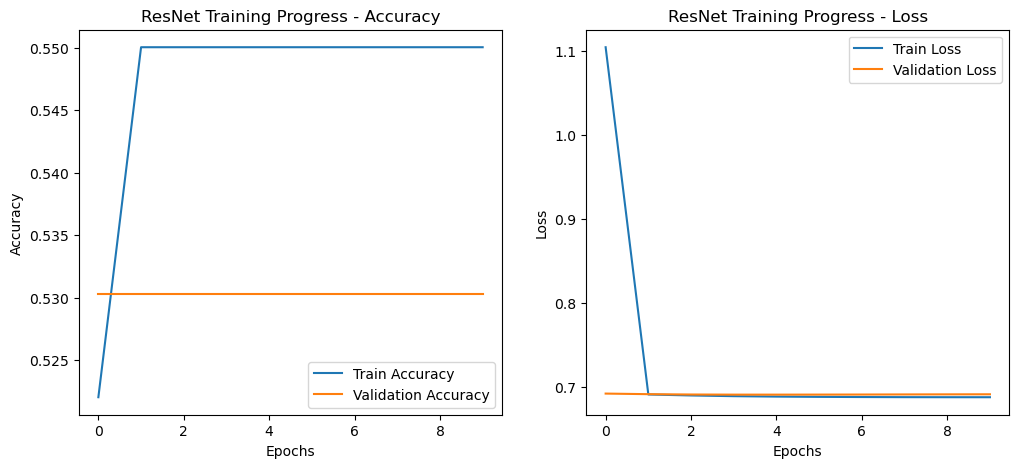

In [6]:
def plot_training_progress(history, title="Training Progress"):
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Example usage for ResNet
plot_training_progress(history_resnet, title="ResNet Training Progress")


21/21 [==============================] - 2s 77ms/step


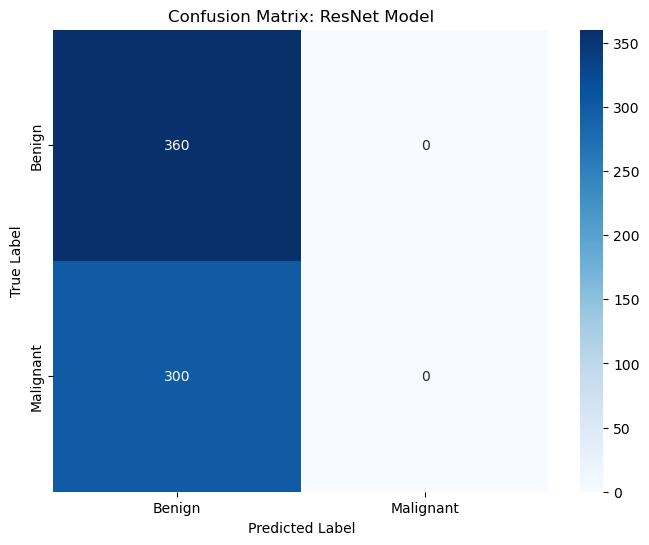

Performance Metrics for ResNet Model:
              precision    recall  f1-score   support

      Benign       0.55      1.00      0.71       360
   Malignant       0.00      0.00      0.00       300

    accuracy                           0.55       660
   macro avg       0.27      0.50      0.35       660
weighted avg       0.30      0.55      0.39       660

Overall Accuracy: 0.55


C:\Users\erfan\anaconda3\envs\my2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\erfan\anaconda3\envs\my2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\erfan\anaconda3\envs\my2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
def evaluate_model(model, X_test, y_test, title="ResNet Evaluation"):

    # Predict probabilities and convert to binary predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

    # Convert y_test to integer format for evaluation
    y_test_int = y_test.astype(int).flatten()

    # Confusion Matrix
    cm = confusion_matrix(y_test_int, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Metrics
    print(f"Performance Metrics for {title}:")
    print(classification_report(y_test_int, y_pred, target_names=['Benign', 'Malignant']))
    print(f"Overall Accuracy: {accuracy_score(y_test_int, y_pred):.2f}")

evaluate_model(model_resnet, X_test, y_test, title="ResNet Model")


### VGG 16

In [9]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()


In [4]:
# Load VGG16 pre-trained model
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_base.trainable = False  # Freeze base layers

# Add custom layers
vgg16_model = Sequential([
    vgg16_base,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
vgg16_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_vgg16 = vgg16_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10, 
    batch_size=16
)

# Evaluate the model
test_loss_vgg16, test_acc_vgg16 = vgg16_model.evaluate(X_test, y_test)
print(f"VGG16 Test Accuracy: {test_acc_vgg16}")


Epoch 1/10
132/132 [==============================] - 14s 83ms/step - loss: 0.6163 - accuracy: 0.7487 - val_loss: 0.4934 - val_accuracy: 0.7330
Epoch 2/10
132/132 [==============================] - 10s 75ms/step - loss: 0.4221 - accuracy: 0.8037 - val_loss: 0.3910 - val_accuracy: 0.8125
Epoch 3/10
132/132 [==============================] - 10s 79ms/step - loss: 0.3908 - accuracy: 0.8269 - val_loss: 0.4080 - val_accuracy: 0.7992
Epoch 4/10
132/132 [==============================] - 10s 73ms/step - loss: 0.3648 - accuracy: 0.8317 - val_loss: 0.3992 - val_accuracy: 0.8049
Epoch 5/10
132/132 [==============================] - 10s 73ms/step - loss: 0.3362 - accuracy: 0.8431 - val_loss: 0.4057 - val_accuracy: 0.8011
Epoch 6/10
132/132 [==============================] - 10s 73ms/step - loss: 0.3297 - accuracy: 0.8388 - val_loss: 0.3504 - val_accuracy: 0.8258
Epoch 7/10
132/132 [==============================] - 10s 74ms/step - loss: 0.3142 - accuracy: 0.8492 - val_loss: 0.3613 - val_accuracy:

In [5]:
# Load VGG19 pre-trained model
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg19_base.trainable = False  # Freeze base layers

# Add custom layers
vgg19_model = Sequential([
    vgg19_base,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
vgg19_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_vgg19 = vgg19_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,  # Adjust as needed
    batch_size=16
)

# Evaluate the model
test_loss_vgg19, test_acc_vgg19 = vgg19_model.evaluate(X_test, y_test)
print(f"VGG19 Test Accuracy: {test_acc_vgg19}")


Epoch 1/10
132/132 [==============================] - 13s 91ms/step - loss: 0.6206 - accuracy: 0.7283 - val_loss: 0.5136 - val_accuracy: 0.7140
Epoch 2/10
132/132 [==============================] - 12s 89ms/step - loss: 0.4844 - accuracy: 0.7705 - val_loss: 0.4329 - val_accuracy: 0.8011
Epoch 3/10
132/132 [==============================] - 12s 89ms/step - loss: 0.4473 - accuracy: 0.8070 - val_loss: 0.8623 - val_accuracy: 0.6439
Epoch 4/10
132/132 [==============================] - 12s 89ms/step - loss: 0.4274 - accuracy: 0.8046 - val_loss: 0.4208 - val_accuracy: 0.7936
Epoch 5/10
132/132 [==============================] - 12s 89ms/step - loss: 0.4162 - accuracy: 0.8217 - val_loss: 0.4180 - val_accuracy: 0.7841
Epoch 6/10
132/132 [==============================] - 12s 90ms/step - loss: 0.3961 - accuracy: 0.8132 - val_loss: 0.4224 - val_accuracy: 0.7765
Epoch 7/10
132/132 [==============================] - 12s 90ms/step - loss: 0.3992 - accuracy: 0.8046 - val_loss: 0.4046 - val_accuracy:

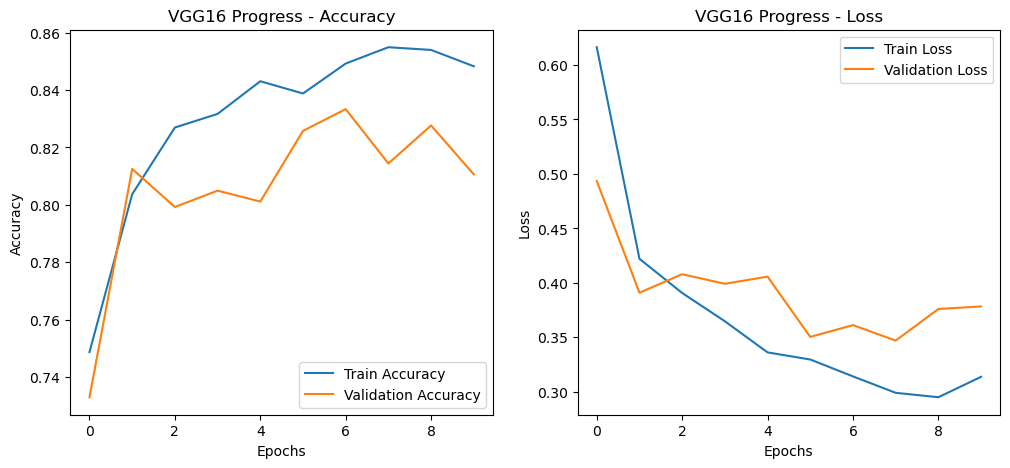

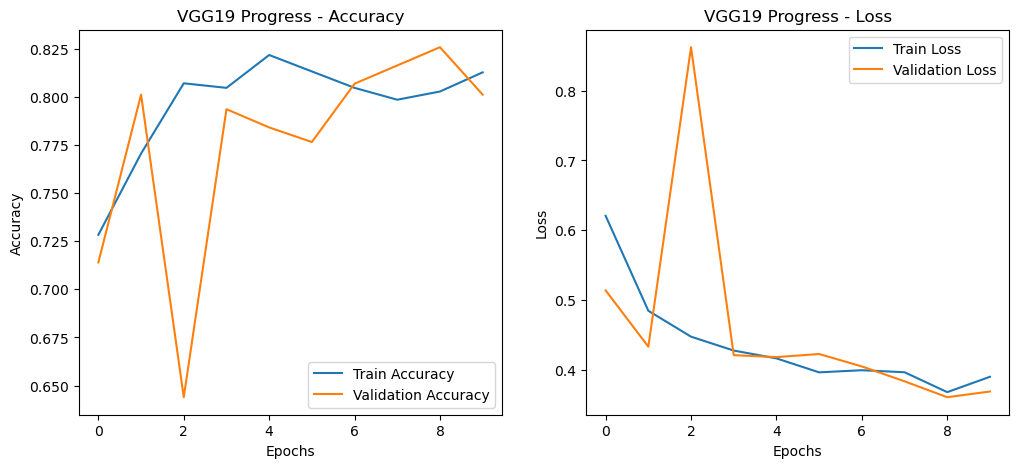

In [6]:
def plot_training_progress(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot progress for VGG16
plot_training_progress(history_vgg16, "VGG16 Progress")

# Plot progress for VGG19
plot_training_progress(history_vgg19, "VGG19 Progress")


21/21 [==============================] - 3s 127ms/step


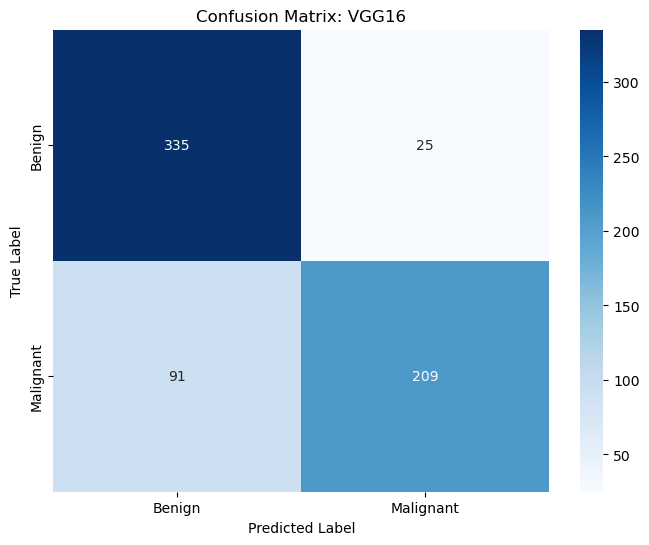

Performance Metrics for VGG16:
              precision    recall  f1-score   support

      Benign       0.79      0.93      0.85       360
   Malignant       0.89      0.70      0.78       300

    accuracy                           0.82       660
   macro avg       0.84      0.81      0.82       660
weighted avg       0.83      0.82      0.82       660

Overall Accuracy: 0.82
21/21 [==============================] - 3s 135ms/step


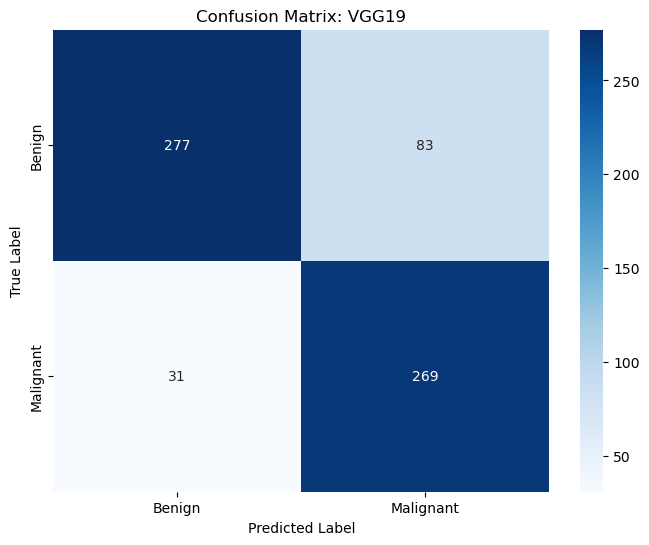

Performance Metrics for VGG19:
              precision    recall  f1-score   support

      Benign       0.90      0.77      0.83       360
   Malignant       0.76      0.90      0.83       300

    accuracy                           0.83       660
   macro avg       0.83      0.83      0.83       660
weighted avg       0.84      0.83      0.83       660

Overall Accuracy: 0.83


In [7]:
def evaluate_model(model, X_test, y_test, title):

    # Predict probabilities and convert to binary predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)  # Threshold at 0.5 for binary classification

    # Convert labels to integer format for evaluation
    y_test_int = y_test.astype(int).flatten()

    # Confusion Matrix
    cm = confusion_matrix(y_test_int, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Metrics
    print(f"Performance Metrics for {title}:")
    print(classification_report(y_test_int, y_pred, target_names=['Benign', 'Malignant']))
    print(f"Overall Accuracy: {accuracy_score(y_test_int, y_pred):.2f}")

evaluate_model(vgg16_model, X_test, y_test, "VGG16")


evaluate_model(vgg19_model, X_test, y_test, "VGG19")

### Inception

In [10]:
# Load Inception-ResNetV2 pre-trained model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Build the complete model
inception_model = Sequential([
    base_model,  # Pre-trained Inception-ResNetV2
    GlobalAveragePooling2D(),  # Reduce feature maps to a vector
    Dense(128, activation='relu'),  # Fully connected layer
    Dropout(0.5),  # Dropout for regularization
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
inception_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_inception = inception_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,  
    batch_size=32  
)

# Evaluate the model
test_loss, test_acc = inception_model.evaluate(X_test, y_test)
print(f"Inception-ResNetV2 Test Accuracy: {test_acc}")


Epoch 1/10
66/66 [==============================] - 21s 229ms/step - loss: 0.5747 - accuracy: 0.7231 - val_loss: 0.4635 - val_accuracy: 0.7860
Epoch 2/10
66/66 [==============================] - 12s 175ms/step - loss: 0.4713 - accuracy: 0.7847 - val_loss: 0.4411 - val_accuracy: 0.8011
Epoch 3/10
66/66 [==============================] - 12s 176ms/step - loss: 0.4239 - accuracy: 0.8023 - val_loss: 0.3989 - val_accuracy: 0.8144
Epoch 4/10
66/66 [==============================] - 12s 176ms/step - loss: 0.3994 - accuracy: 0.8127 - val_loss: 0.3985 - val_accuracy: 0.8258
Epoch 5/10
66/66 [==============================] - 12s 177ms/step - loss: 0.3821 - accuracy: 0.8260 - val_loss: 0.3998 - val_accuracy: 0.7955
Epoch 6/10
66/66 [==============================] - 12s 180ms/step - loss: 0.3714 - accuracy: 0.8303 - val_loss: 0.3857 - val_accuracy: 0.8163
Epoch 7/10
66/66 [==============================] - 12s 181ms/step - loss: 0.3560 - accuracy: 0.8359 - val_loss: 0.3792 - val_accuracy: 0.8277

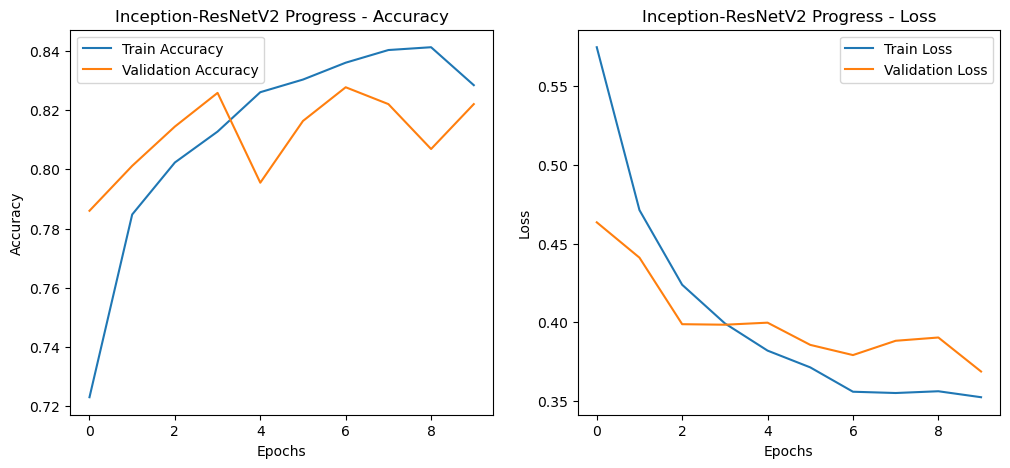

In [11]:
def plot_training_progress(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot progress
plot_training_progress(history_inception, "Inception-ResNetV2 Progress")


21/21 [==============================] - 5s 151ms/step


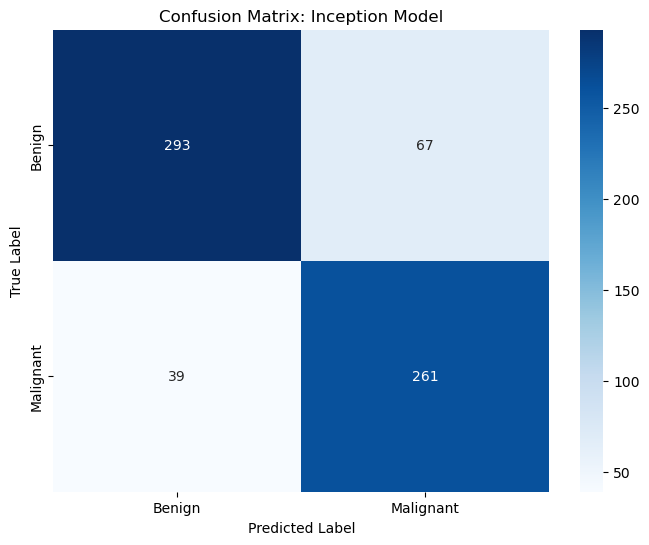

Performance Metrics for Inception Model:
              precision    recall  f1-score   support

      Benign       0.88      0.81      0.85       360
   Malignant       0.80      0.87      0.83       300

    accuracy                           0.84       660
   macro avg       0.84      0.84      0.84       660
weighted avg       0.84      0.84      0.84       660

Overall Accuracy: 0.84


In [12]:
def evaluate_model(model, X_test, y_test, title="Inception Evaluation"):

    # Predict probabilities and convert to binary predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

    # Convert y_test to integer format for evaluation
    y_test_int = y_test.astype(int).flatten()

    # Confusion Matrix
    cm = confusion_matrix(y_test_int, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Metrics
    print(f"Performance Metrics for {title}:")
    print(classification_report(y_test_int, y_pred, target_names=['Benign', 'Malignant']))
    print(f"Overall Accuracy: {accuracy_score(y_test_int, y_pred):.2f}")

evaluate_model(inception_model, X_test, y_test, title="Inception Model")


### MobileNetV3 

In [4]:
# Load MobileNetV3 pre-trained model
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom classification layers
model_MobileNetV3Large = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Pool the feature maps into a single vector
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model_MobileNetV3Large.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_model_MobileNetV3Large = model_MobileNetV3Large.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

# Evaluate the model
test_loss, test_acc = model_MobileNetV3Large.evaluate(X_test, y_test)
print(f"MobileNetV3 Test Accuracy: {test_acc}")


Epoch 1/10
66/66 [==============================] - 8s 71ms/step - loss: 0.7084 - accuracy: 0.5249 - val_loss: 0.6903 - val_accuracy: 0.5303
Epoch 2/10
66/66 [==============================] - 3s 45ms/step - loss: 0.6927 - accuracy: 0.5386 - val_loss: 0.6895 - val_accuracy: 0.5303
Epoch 3/10
66/66 [==============================] - 3s 45ms/step - loss: 0.6908 - accuracy: 0.5401 - val_loss: 0.6899 - val_accuracy: 0.5303
Epoch 4/10
66/66 [==============================] - 3s 45ms/step - loss: 0.6864 - accuracy: 0.5467 - val_loss: 0.6927 - val_accuracy: 0.5303
Epoch 5/10
66/66 [==============================] - 3s 49ms/step - loss: 0.6885 - accuracy: 0.5477 - val_loss: 0.6895 - val_accuracy: 0.5303
Epoch 6/10
66/66 [==============================] - 3s 50ms/step - loss: 0.6870 - accuracy: 0.5543 - val_loss: 0.6913 - val_accuracy: 0.5303
Epoch 7/10
66/66 [==============================] - 3s 47ms/step - loss: 0.6867 - accuracy: 0.5529 - val_loss: 0.6892 - val_accuracy: 0.5568
Epoch 8/10
66

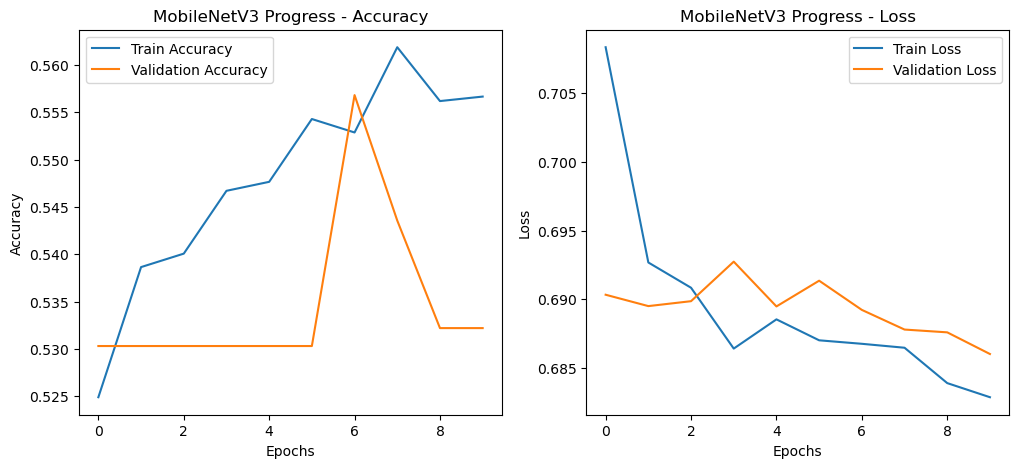

In [7]:
def plot_training_progress(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot progress
plot_training_progress(history_model_MobileNetV3Large, "MobileNetV3 Progress")


21/21 [==============================] - 1s 33ms/step


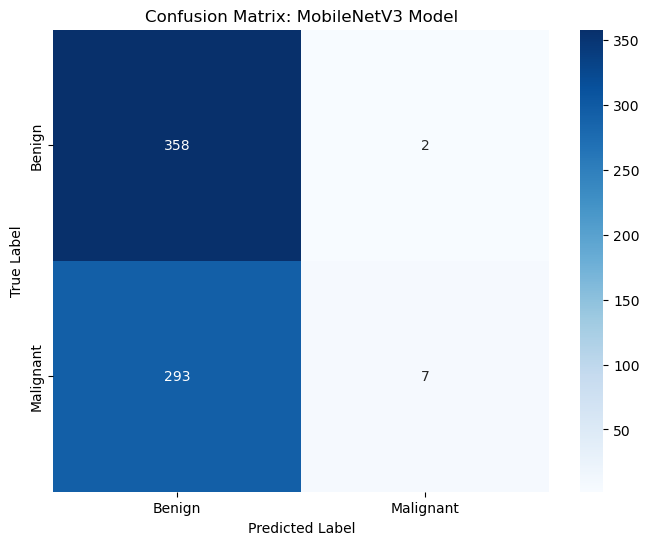

Performance Metrics for MobileNetV3 Model:
              precision    recall  f1-score   support

      Benign       0.55      0.99      0.71       360
   Malignant       0.78      0.02      0.05       300

    accuracy                           0.55       660
   macro avg       0.66      0.51      0.38       660
weighted avg       0.65      0.55      0.41       660

Overall Accuracy: 0.55


In [8]:
def evaluate_model(model, X_test, y_test, title):

    # Predict probabilities and convert to binary predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

    # Convert y_test to integer format for evaluation
    y_test_int = y_test.astype(int).flatten()

    # Confusion Matrix
    cm = confusion_matrix(y_test_int, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Metrics
    print(f"Performance Metrics for {title}:")
    print(classification_report(y_test_int, y_pred, target_names=['Benign', 'Malignant']))
    print(f"Overall Accuracy: {accuracy_score(y_test_int, y_pred):.2f}")

# Example usage for Inception model
evaluate_model(model_MobileNetV3Large, X_test, y_test, title="MobileNetV3 Model")


In [4]:
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Add custom classification layers
model_MobileNetV3Large_fine_tune = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Pool the feature maps into a single vector
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])


# Recompile the model with a lower learning rate
model_MobileNetV3Large_fine_tune.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine_tune = model_MobileNetV3Large_fine_tune.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=16
)
test_loss, test_acc = model_MobileNetV3Large_fine_tune.evaluate(X_test, y_test)
print(f"MobileNetV3 Fine tune Test Accuracy: {test_acc}")

Epoch 1/5
132/132 [==============================] - 21s 113ms/step - loss: 0.4874 - accuracy: 0.7601 - val_loss: 0.8034 - val_accuracy: 0.4697
Epoch 2/5
132/132 [==============================] - 14s 104ms/step - loss: 0.3171 - accuracy: 0.8563 - val_loss: 0.8154 - val_accuracy: 0.4697
Epoch 3/5
132/132 [==============================] - 13s 101ms/step - loss: 0.2384 - accuracy: 0.9023 - val_loss: 0.8663 - val_accuracy: 0.4697
Epoch 4/5
132/132 [==============================] - 14s 104ms/step - loss: 0.1787 - accuracy: 0.9374 - val_loss: 0.9589 - val_accuracy: 0.4697
Epoch 5/5
21/21 [==============================] - 2s 55ms/step - loss: 1.1483 - accuracy: 0.4545
MobileNetV3 Fine tune Test Accuracy: 0.4545454680919647


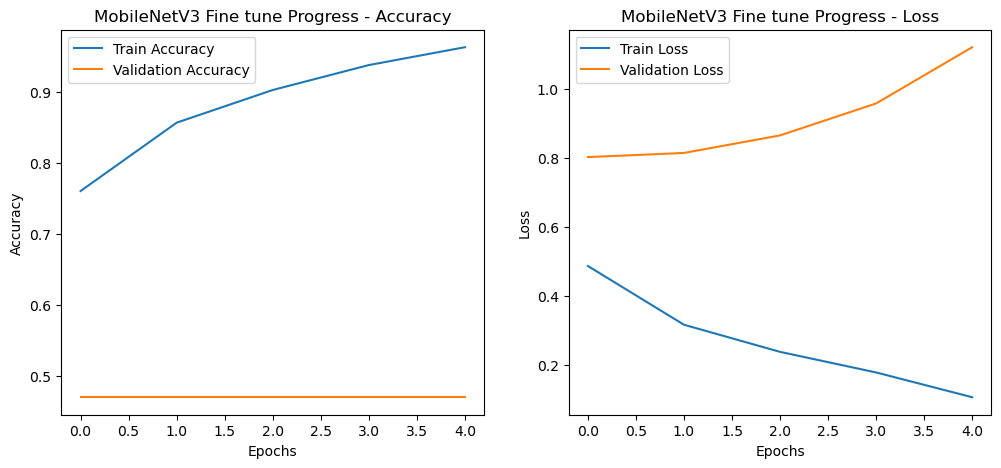

In [6]:
def plot_training_progress(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
plot_training_progress(history_fine_tune, "MobileNetV3 Fine tune Progress")


21/21 [==============================] - 1s 33ms/step


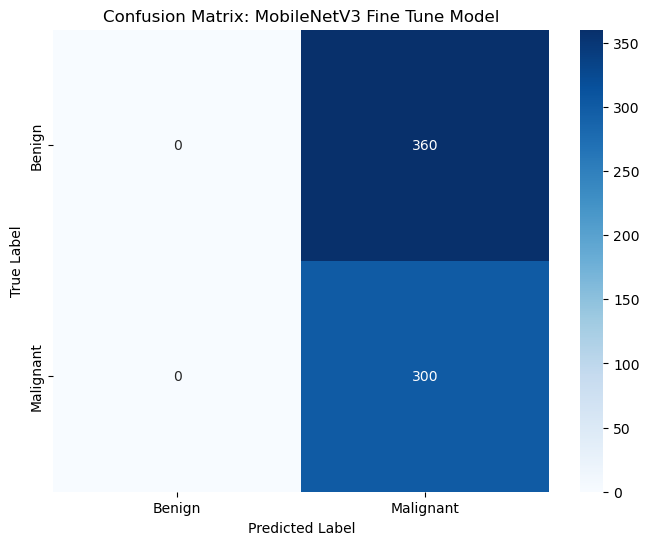

Performance Metrics for MobileNetV3 Fine Tune Model:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       360
   Malignant       0.45      1.00      0.62       300

    accuracy                           0.45       660
   macro avg       0.23      0.50      0.31       660
weighted avg       0.21      0.45      0.28       660

Overall Accuracy: 0.45


C:\Users\erfan\anaconda3\envs\my2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\erfan\anaconda3\envs\my2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\erfan\anaconda3\envs\my2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
def evaluate_model(model, X_test, y_test, title="Inception Evaluation"):

    # Predict probabilities and convert to binary predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

    # Convert y_test to integer format for evaluation
    y_test_int = y_test.astype(int).flatten()

    # Confusion Matrix
    cm = confusion_matrix(y_test_int, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Metrics
    print(f"Performance Metrics for {title}:")
    print(classification_report(y_test_int, y_pred, target_names=['Benign', 'Malignant']))
    print(f"Overall Accuracy: {accuracy_score(y_test_int, y_pred):.2f}")

evaluate_model(model_MobileNetV3Large_fine_tune, X_test, y_test, title="MobileNetV3 Fine Tune Model")


### Xception 

In [8]:
# Load Xception pre-trained model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom classification layers
model_Xception = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Pool feature maps to a single vector
    Dense(128, activation='relu'),  # Fully connected layer
    Dropout(0.5),  # Regularization
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model_Xception.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_Xception = model_Xception.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

# Evaluate the model
test_loss, test_acc = model_Xception.evaluate(X_test, y_test)
print(f"Xception Test Accuracy: {test_acc}")


Epoch 1/10
66/66 [==============================] - 11s 141ms/step - loss: 0.5202 - accuracy: 0.7406 - val_loss: 0.4553 - val_accuracy: 0.7803
Epoch 2/10
66/66 [==============================] - 8s 125ms/step - loss: 0.3968 - accuracy: 0.8170 - val_loss: 0.4124 - val_accuracy: 0.7955
Epoch 3/10
66/66 [==============================] - 9s 129ms/step - loss: 0.3557 - accuracy: 0.8397 - val_loss: 0.3733 - val_accuracy: 0.8182
Epoch 4/10
66/66 [==============================] - 8s 119ms/step - loss: 0.3252 - accuracy: 0.8502 - val_loss: 0.3577 - val_accuracy: 0.8295
Epoch 5/10
66/66 [==============================] - 8s 129ms/step - loss: 0.3013 - accuracy: 0.8668 - val_loss: 0.3632 - val_accuracy: 0.8144
Epoch 6/10
66/66 [==============================] - 8s 127ms/step - loss: 0.2817 - accuracy: 0.8772 - val_loss: 0.3658 - val_accuracy: 0.8163
Epoch 7/10
66/66 [==============================] - 8s 126ms/step - loss: 0.2591 - accuracy: 0.8872 - val_loss: 0.3754 - val_accuracy: 0.8182
Epoch

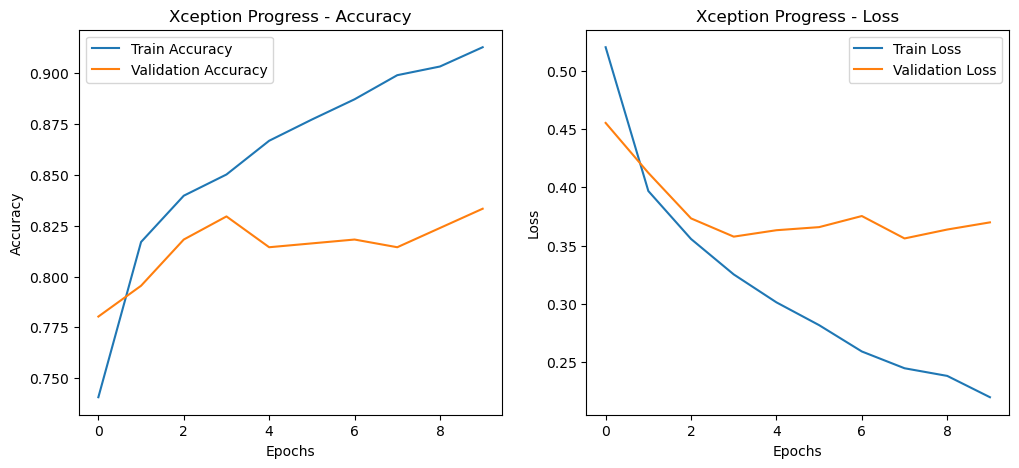

In [9]:
plot_training_progress(history_Xception, "Xception Progress")


21/21 [==============================] - 2s 86ms/step


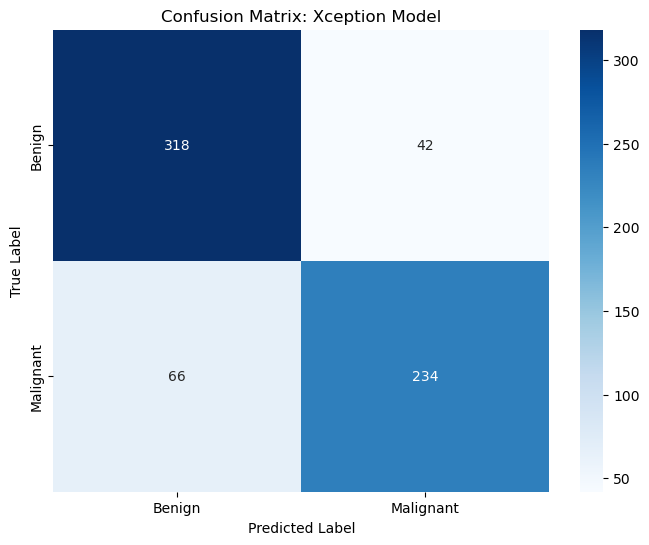

Performance Metrics for Xception Model:
              precision    recall  f1-score   support

      Benign       0.83      0.88      0.85       360
   Malignant       0.85      0.78      0.81       300

    accuracy                           0.84       660
   macro avg       0.84      0.83      0.83       660
weighted avg       0.84      0.84      0.84       660

Overall Accuracy: 0.84


In [10]:
evaluate_model(model_Xception, X_test, y_test, title="Xception Model")


In [4]:
# Unfreeze the base model for fine-tuning
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
# Add custom classification layers
model_Xception_fine_tune = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Pool feature maps to a single vector
    Dense(128, activation='relu'),  # Fully connected layer
    Dropout(0.5),  # Regularization
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model_Xception_fine_tune.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine_tune = model_Xception_fine_tune.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=8
)


Epoch 1/5
264/264 [==============================] - 45s 155ms/step - loss: 0.5208 - accuracy: 0.7307 - val_loss: 0.9039 - val_accuracy: 0.7405
Epoch 2/5
264/264 [==============================] - 40s 153ms/step - loss: 0.4443 - accuracy: 0.8028 - val_loss: 0.3526 - val_accuracy: 0.8295
Epoch 3/5
264/264 [==============================] - 39s 147ms/step - loss: 0.4038 - accuracy: 0.8222 - val_loss: 0.3541 - val_accuracy: 0.8144
Epoch 4/5
264/264 [==============================] - 38s 143ms/step - loss: 0.3574 - accuracy: 0.8459 - val_loss: 0.4276 - val_accuracy: 0.8106
Epoch 5/5
264/264 [==============================] - 38s 145ms/step - loss: 0.3965 - accuracy: 0.8383 - val_loss: 0.3410 - val_accuracy: 0.8636


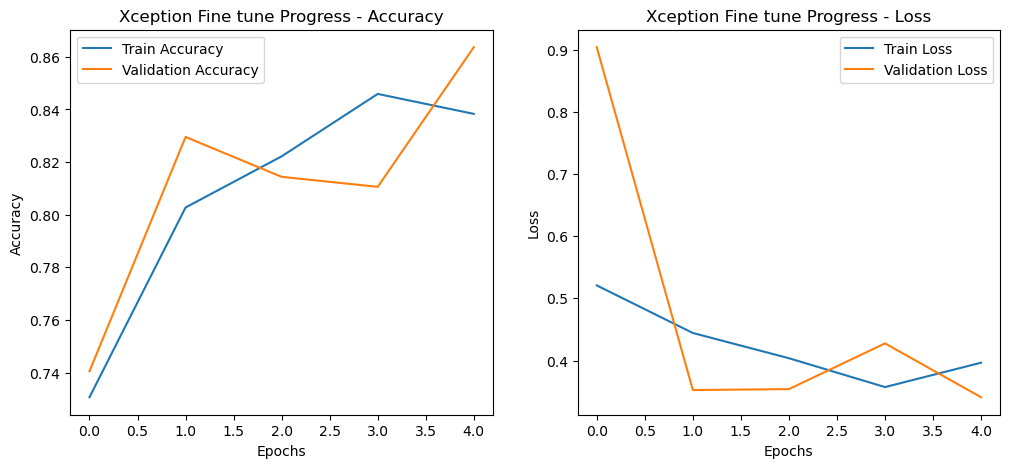

In [5]:
def plot_training_progress(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
plot_training_progress(history_fine_tune, "Xception Fine tune Progress")


21/21 [==============================] - 3s 113ms/step


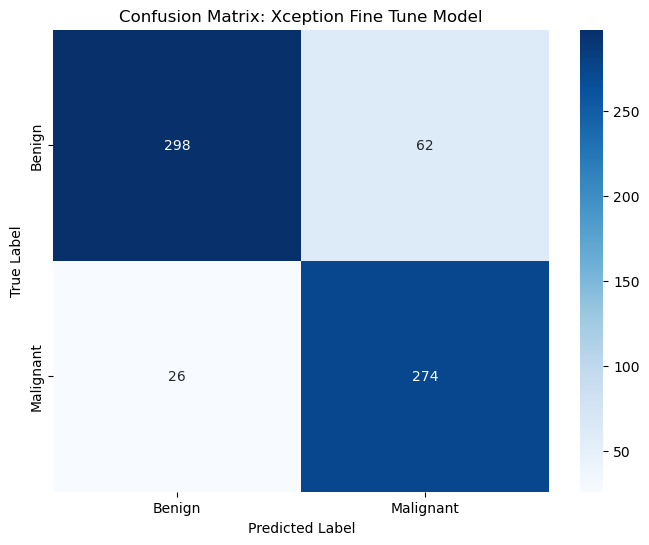

Performance Metrics for Xception Fine Tune Model:
              precision    recall  f1-score   support

      Benign       0.92      0.83      0.87       360
   Malignant       0.82      0.91      0.86       300

    accuracy                           0.87       660
   macro avg       0.87      0.87      0.87       660
weighted avg       0.87      0.87      0.87       660

Overall Accuracy: 0.87


In [6]:
def evaluate_model(model, X_test, y_test, title="Inception Evaluation"):

    # Predict probabilities and convert to binary predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

    # Convert y_test to integer format for evaluation
    y_test_int = y_test.astype(int).flatten()

    # Confusion Matrix
    cm = confusion_matrix(y_test_int, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Metrics
    print(f"Performance Metrics for {title}:")
    print(classification_report(y_test_int, y_pred, target_names=['Benign', 'Malignant']))
    print(f"Overall Accuracy: {accuracy_score(y_test_int, y_pred):.2f}")

evaluate_model(model_Xception_fine_tune, X_test, y_test, title="Xception Fine Tune Model")
